## Hovmöller diagram of upper slope ADCP

### NEPTUNE - ADCP metadata

**Data points every 2 SECONDS **

platform_depth = 395. ;
site_name = "UpperSlope_IP_2012-06" ;
device_name = "RDI Workhorse Long Ranger ADCP 75 kHz (9202)" ;
		
**dimensions**:
	
    time = 33654 ;
	depth = 50 ;
	latitude = 1 ;
	longitude = 1 ;
    
    float u(time, depth) ;
		u:standard_name = "eastward_sea_water_velocity" ;
		u:long_name = "eastward sea water velocity" ;
		u:units = "meters/second" ;
		u:_FillValue = -9999999.f ;
	float v(time, depth) ;
		v:standard_name = "northward_sea_water_velocity" ;
		v:long_name = "northward sea water velocity" ;
		v:units = "meters/second" ;
		v:_FillValue = -9999999.f ;
	float w(time, depth) ;
		w:standard_name = "upward_sea_water_velocity" ;
		w:long_name = "upward sea water velocity" ;
		w:units = "meters/second" ;
		w:_FillValue = -9999999.f ;
	float temp(time) ;
		temp:standard_name = "sea_water_temperature" ;
		temp:long_name = "sea water temperature" ;
		temp:units = "K" ;
		temp:_FillValue = -9999999.f ;

In [1]:
import datetime as dtm      # Python's standard date and time library
import dateutil as dutil    # Powerful datetime extensions
import glob
from math import *
from matplotlib.dates import num2date
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
from salishsea_tools.tidetools import filter_timeseries
import seaborn as sns
import scipy.io
import xarray as xr


/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def ONC_to_pytime(time):
    '''
    Transform dates into something python can use.
    Returns python datetimes array from time.
    '''
    date1 = dtm.date(1, 1, 1)
    date2 = dtm.date(1970,1,1)
    timedelta1 = date2 - date1
    python_datetimes = np.array([(dtm.datetime.fromordinal(int(tt)) 
                                  + dtm.timedelta(days=tt%1)
                                  + timedelta1 
                                  + dtm.timedelta(days=1)) for tt in time])
    return(python_datetimes)

def filter_timeseries_1D(record, winlen=39, method='box'):
    """Filter a timeseries.
    It didn't work for 1D arrays, so I edited it.
    Developed for wind and tidal filtering, but can be modified for use
    with a variety of timeseries data. The data record should be at least
    half a window length longer at either end than the period of interest
    to accommodate window length shrinking near the array edges.

    *This function can only operate along the 0 axis. Please modify to include
    an axis argument in the future.*
    
    Types of filters (*please add to these*):
    * **box**: simple running mean
    * **doodson**: Doodson bandpass filter (39 winlen required)
    
    :arg record: timeseries record to be filtered
    :type record: :py:class:`numpy.ndarray`, :py:class:`xarray.DataArray`,
                  or :py:class:`netCDF4.Variable`
    
    :arg winlen: window length
    :type winlen: integer
    
    :arg method: type of filter (ex. 'box', 'doodson', etc.)
    :type method: string
    
    :returns filtered: filtered timeseries
    :rtype: same as record
    """
    
    # Preallocate filtered record
    filtered = record.copy()
    
    # Length along time axis
    record_length = record.shape[0]

    # Window length
    w = (winlen - 1) // 2
    
    # Construct weight vector
    weight = np.zeros(w, dtype=int)
    
    # Select filter method
    if method is 'doodson':
        # Doodson bandpass filter (winlen must be 39)
        weight[[1, 2, 5, 6, 10, 11, 13, 16, 18]] = 1
        weight[[0, 3, 8]] = 2
        centerval = 0
    elif method is 'box':
        # Box filter
        weight[:] = 1
        centerval = 1
    else:
        raise ValueError('Invalid filter method: {}'.format(method))
    
    # Loop through record
    for i in range(record_length):
        
        # Adjust window length for end cases
        W = min(i, w, record_length-i-1)
        Weight = weight[:W]
        Weight = np.append(Weight[::-1], np.append(centerval, Weight))
        Weight = (Weight/sum(Weight, centerval))
        
        # Expand weight dims so it can operate on record window
        for dim in range(record.ndim - 1):
            Weight = Weight[:, np.newaxis]
        
        # Apply mean over window length
        filtered[i] = np.sum(record[i-W:i+W+1] * Weight, axis=0)
    
    return filtered

In [60]:
# INPUT 
filenames = glob.glob('ADCP75kHzPOD2/2014/BarkleyCanyon_UpperSlope_ADCP75kHz_2014*.nc')

data = xr.open_dataset(filenames[0])
uu = data.u.resample('1h',dim='time')
vv = data.v.resample('1h',dim='time')
ww = data.w.resample('1h',dim='time')
TT = data.temp.resample('1h',dim='time')

for filename in filenames[1:]:
    print(filename)
    data = xr.open_dataset(filename)
    u_temporal = data.u.resample('1h',dim='time')
    v_temporal = data.v.resample('1h',dim='time')
    w_temporal = data.w.resample('1h',dim='time')
    T_temporal = data.temp.resample('1h',dim='time')
    
    # I need to align depth before concat because some files have 2 decimals (eg. 106.59m) and some have 1 (eg. 106.6m)
    uu = xr.concat([uu, u_temporal.reindex(method='nearest',depth=uu.depth)] , dim='time') 
    vv = xr.concat([vv, v_temporal.reindex(method='nearest',depth=vv.depth)] , dim='time')
    ww = xr.concat([ww, w_temporal.reindex(method='nearest',depth=ww.depth)] , dim='time')
    TT = xr.concat([TT, T_temporal] , dim='time') # no need to align this one, its only dim is time.
    

ADCP75kHzPOD2/2014/BarkleyCanyon_UpperSlope_ADCP75kHz_20140502T000001Z_20140502T235959Z-binMapLinearInterp.nc
ADCP75kHzPOD2/2014/BarkleyCanyon_UpperSlope_ADCP75kHz_20140503T000001Z_20140503T184148Z-binMapLinearInterp.nc
ADCP75kHzPOD2/2014/BarkleyCanyon_UpperSlope_ADCP75kHz_20140503T185857Z_20140503T235959Z-binMapLinearInterp.nc
ADCP75kHzPOD2/2014/BarkleyCanyon_UpperSlope_ADCP75kHz_20140504T000001Z_20140504T235959Z-binMapLinearInterp.nc
ADCP75kHzPOD2/2014/BarkleyCanyon_UpperSlope_ADCP75kHz_20140505T000001Z_20140505T235959Z-binMapLinearInterp.nc
ADCP75kHzPOD2/2014/BarkleyCanyon_UpperSlope_ADCP75kHz_20140506T000001Z_20140506T235959Z-binMapLinearInterp.nc
ADCP75kHzPOD2/2014/BarkleyCanyon_UpperSlope_ADCP75kHz_20140507T000001Z_20140507T235959Z-binMapLinearInterp.nc
ADCP75kHzPOD2/2014/BarkleyCanyon_UpperSlope_ADCP75kHz_20140508T000001Z_20140508T235958Z-binMapLinearInterp.nc
ADCP75kHzPOD2/2014/BarkleyCanyon_UpperSlope_ADCP75kHz_20140509T000000Z_20140509T235958Z-binMapLinearInterp.nc
ADCP75kHzP

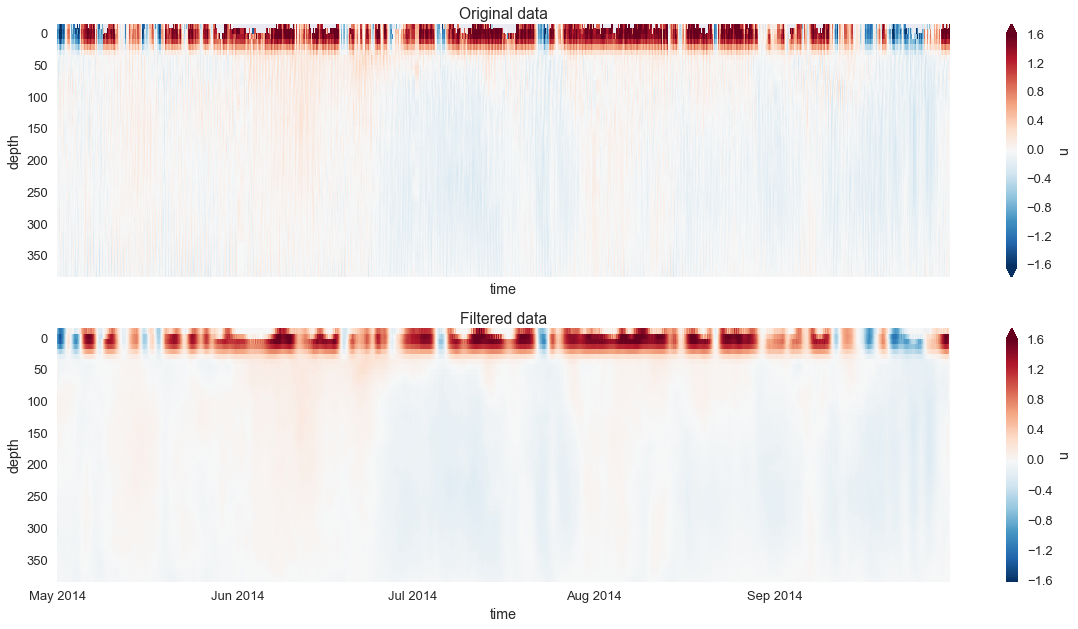

In [82]:
# filter dataset along ax 0 (time)
uu_filt = filter_timeseries(uu, winlen=39, method='doodson')

# plot
sns.set_context('talk')
fig,ax = plt.subplots(2,1,figsize = (20,10), sharex = True)
uu.plot(x='time',
        y='depth',
        ax=ax[0],
        yincrease=False,
        cmap='RdBu_r',
        vmax=1.6,
        vmin=-1.6
       )
ax[0].set_title('Original data')

uu_filt.plot(x='time',
             y='depth',
             ax=ax[1],
             yincrease=False,
             cmap='RdBu_r',
             vmax=1.6,
             vmin=-1.6
            )
ax[1].set_title('Filtered data')



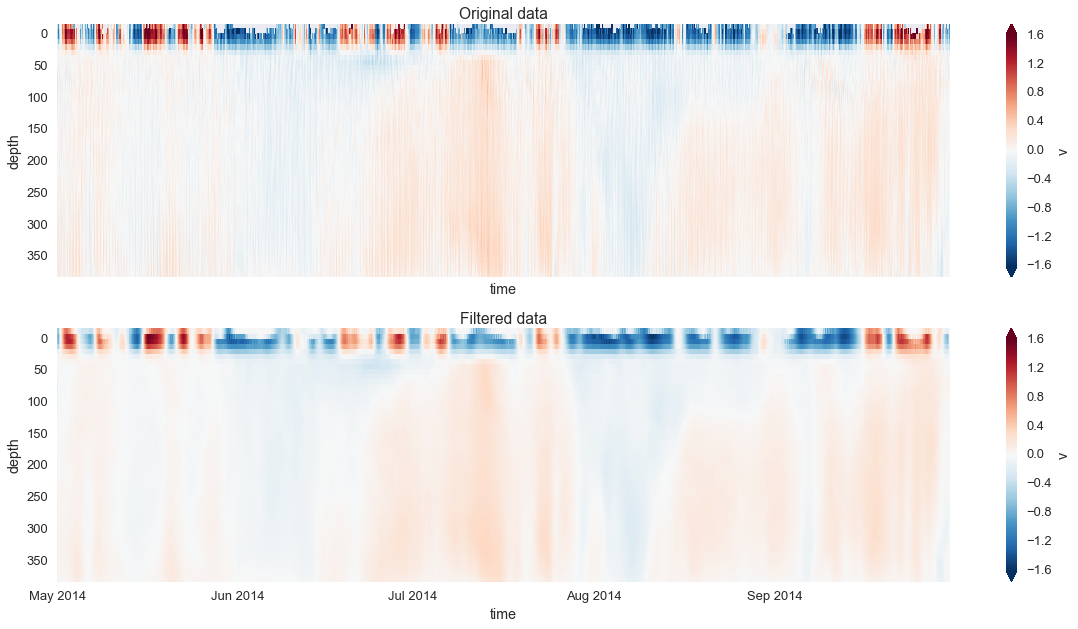

In [83]:
# filter dataset along ax 0 (time)
vv_filt = filter_timeseries(vv, winlen=39, method='doodson')

# plot
sns.set_context('talk')
fig,ax = plt.subplots(2,1,figsize = (20,10), sharex = True)
vv.plot(x='time',
        y='depth',
        ax=ax[0],
        yincrease=False,
        cmap='RdBu_r',
        vmax=1.6,
        vmin=-1.6
       )
ax[0].set_title('Original data')

vv_filt.plot(x='time',
             y='depth',
             ax=ax[1],
             yincrease=False,
             cmap='RdBu_r',
             vmax=1.6,
             vmin=-1.6
            )
ax[1].set_title('Filtered data')


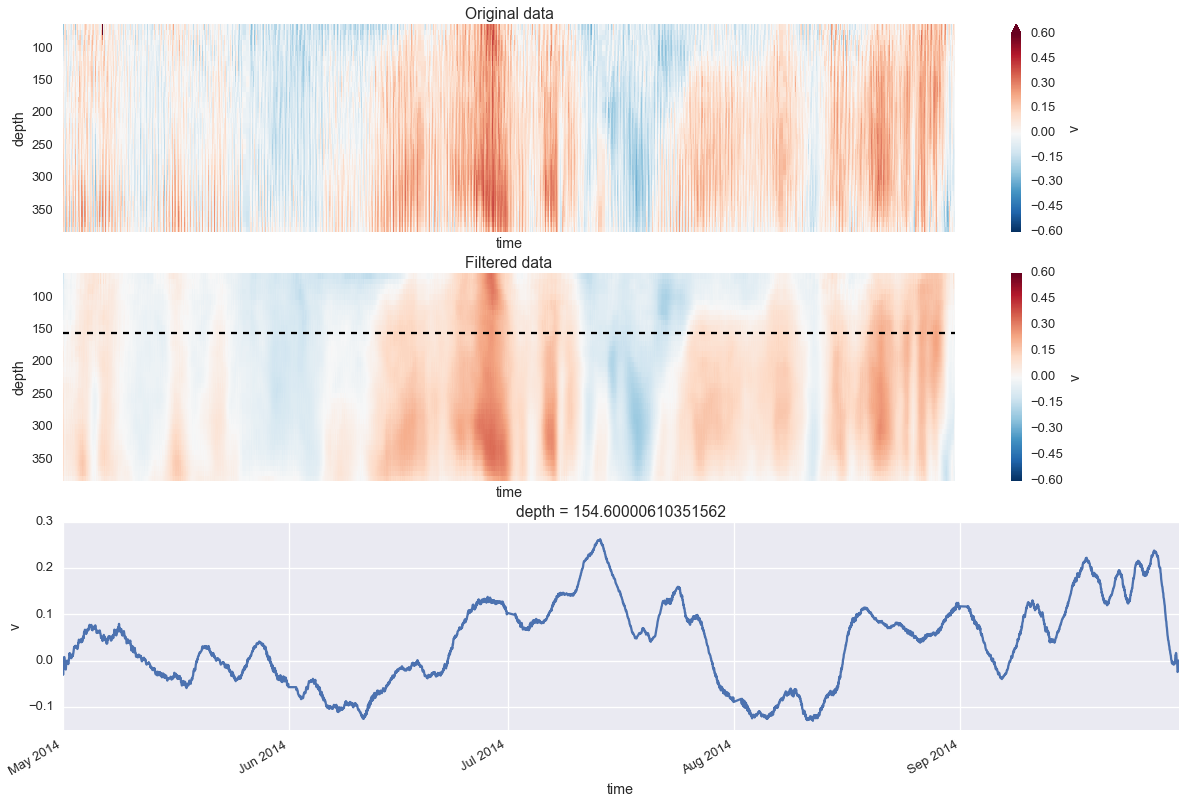

In [111]:
# filter dataset along ax 0 (time)
vv_filt = filter_timeseries(vv, winlen=39, method='doodson')

# plot
sns.set_context('talk')
fig,ax = plt.subplots(3,1,figsize = (20,14), sharex = True)
vv[:,:-10].plot(x='time',
        y='depth',
        ax=ax[0],
        yincrease=False,
        cmap='RdBu_r',
        vmax=0.6,
        vmin=-0.6
       )
ax[0].set_title('Original data')

vv_filt[:,:-10].plot(x='time',
             y='depth',
             ax=ax[1],
             yincrease=False,
             cmap='RdBu_r',
             vmax=0.6,
             vmin=-0.6
            )
ax[1].axhline(data.depth[28], color='black', linestyle='--')
ax[1].set_title('Filtered data')

vv_filt.isel(depth=28).plot(ax=ax[2])



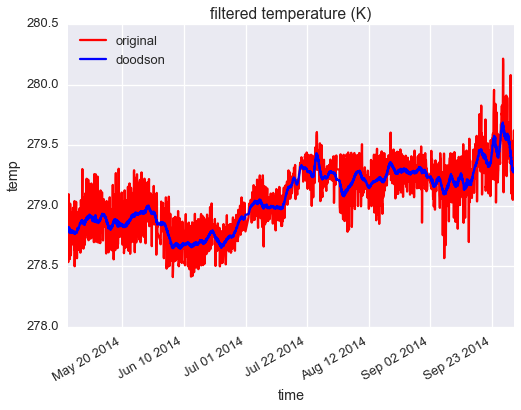

In [88]:
sns.set_context('talk')

fig,ax1 = plt.subplots(1,1,figsize = (8,6))
TT_filt = filter_timeseries_1D(TT, winlen=39, method='doodson')
TT[10:-10].plot(ax=ax1, color='red', label = 'original')
TT_filt[10:-10].plot(ax=ax1, color='blue', label='doodson')
ax1.legend(loc=0)
ax1.set_title('filtered temperature (K)')

In [110]:
print(data.depth[28])

<xarray.DataArray 'depth' ()>
array(154.58999633789062, dtype=float32)
Coordinates:
    depth    float32 154.59
Attributes:
    standard_name: depth
    long_name: approx. water depth of measurement bin
    units: meters
    axis: Z
    positive: down
